In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [37]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import lightgbm as lgb
import folium

In [3]:
train = pd.read_csv('/content/drive/MyDrive/bus/train.csv')
test = pd.read_csv('/content/drive/MyDrive/bus/test.csv')
submission = pd.read_csv('/content/drive/MyDrive/bus/submission_제출양식.csv')

In [4]:
train.head()

,id,date,route_id,vh_id,route_nm,now_latitude,now_longitude,now_station,now_arrive_time,distance,next_station,next_latitude,next_longitude,next_arrive_time
0,0,2019-10-15,405136001,7997025,360-1,33.456267,126.551750,제주대학교입구,06시,266.0,제대마을,33.457724,126.554014,24
1,1,2019-10-15,405136001,7997025,360-1,33.457724,126.554014,제대마을,06시,333.0,제대아파트,33.458783,126.557353,36
2,2,2019-10-15,405136001,7997025,360-1,33.458783,126.557353,제대아파트,06시,415.0,제주대학교,33.459893,126.561624,40
3,3,2019-10-15,405136001,7997025,360-1,33.479705,126.543811,남국원(아라방면),06시,578.0,제주여자중고등학교(아라방면),33.484860,126.542928,42
4,4,2019-10-15,405136001,7997025,360-1,33.485662,126.494923,도호동,07시,374.0,은남동,33.485822,126.490897,64


In [5]:
test.head()

,id,date,route_id,vh_id,route_nm,now_latitude,now_longitude,now_station,now_arrive_time,distance,next_station,next_latitude,next_longitude
0,210457,2019-10-29,405136001,7997025,360-1,33.457724,126.554014,제대마을,07시,333.0,제대아파트,33.458783,126.557353
1,210458,2019-10-29,405136001,7997025,360-1,33.458783,126.557353,제대아파트,07시,415.0,제주대학교,33.459893,126.561624
2,210459,2019-10-29,405136001,7997025,360-1,33.478867,126.483833,한라중학교/부영아파트,08시,417.0,대림2차아파트,33.478850,126.488350
3,210460,2019-10-29,405136001,7997025,360-1,33.478850,126.488350,대림2차아파트,08시,334.0,연동대림1차아파트,33.480700,126.489933
4,210461,2019-10-29,405136001,7997025,360-1,33.480700,126.489933,연동대림1차아파트,08시,550.0,케이티앤지,33.482077,126.485355


In [6]:
submission.head()

,id,next_arrive_time
0,210457,0
1,210458,0
2,210459,0
3,210460,0
4,210461,0


In [7]:
train.shape

(210457, 14)

id 기준 0~210456까지 총 210457개의 row와 14개의 칼럼이 존재한다.

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210457 entries, 0 to 210456
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                210457 non-null  int64  
 1   date              210457 non-null  object 
 2   route_id          210457 non-null  int64  
 3   vh_id             210457 non-null  int64  
 4   route_nm          210457 non-null  object 
 5   now_latitude      210457 non-null  float64
 6   now_longitude     210457 non-null  float64
 7   now_station       210457 non-null  object 
 8   now_arrive_time   210457 non-null  object 
 9   distance          210457 non-null  float64
 10  next_station      210457 non-null  object 
 11  next_latitude     210457 non-null  float64
 12  next_longitude    210457 non-null  float64
 13  next_arrive_time  210457 non-null  int64  
dtypes: float64(5), int64(4), object(5)
memory usage: 22.5+ MB


- id : 해당 데이터의 고유한 ID
- date : 버스 운행 날짜
- route_id : 버스 노선 ID
- vh_id : 버스 ID
- route_nm : 버스 노선 실제 번호
- now_latitude : 현재 정류소의 위도
- now_longtitude : 현재 정류소의 경도
- now_station : 현재 정류소 이름
- now_arrive_time : 현재 정류장에 도착한 시간
- distance : 현재 정류장에서 다음 정류장까지 실제 이동한 거리
- next_station : 다음 정류소 이름
- next_latitude : 다음 정류서의 위도
- next_longtitude : 다음 정류소의 경도
- next_arrive_time : target, 다음 정류장에 도착할때 까지 걸린 시간(초)



In [9]:
train.isnull().sum()

# 결측치는 존재하지 않는다.

id                  0
date                0
route_id            0
vh_id               0
route_nm            0
now_latitude        0
now_longitude       0
now_station         0
now_arrive_time     0
distance            0
next_station        0
next_latitude       0
next_longitude      0
next_arrive_time    0
dtype: int64

In [10]:
test.isnull().sum()

id                 0
date               0
route_id           0
vh_id              0
route_nm           0
now_latitude       0
now_longitude      0
now_station        0
now_arrive_time    0
distance           0
next_station       0
next_latitude      0
next_longitude     0
dtype: int64

In [11]:
train.route_id.unique()

array([405136001, 405136002, 405136007, 405136012, 405136521, 405136522,
       405320111, 405320112, 405320113, 405320114, 405320115, 405320116,
       405320117, 405320118, 405320121, 405320122, 405320124, 405320126,
       405320127, 405328101, 405328102])

In [12]:
test.route_id.unique()

array([405136001, 405136002, 405136007, 405136012, 405136521, 405136522,
       405320111, 405320112, 405320113, 405320114, 405320115, 405320116,
       405320117, 405320118, 405320121, 405320122, 405320124, 405320126,
       405320127, 405328101, 405328102])

In [13]:
train.route_id.nunique()

21

In [14]:
test.route_id.nunique()

21

총 21 개의 루트가 존재한다.



In [15]:
train.vh_id.unique()

array([7997025, 7997034, 7997035, 7997040, 7997044, 7997058, 7997064,
       7997080, 7997118, 7997124, 7997043, 7997082, 7997111, 7997112,
       7997067, 7997028, 7997033, 7997001, 7997031, 7997070, 7997077,
       7997087, 7997089, 7997002, 7997022, 7997032, 7997056, 7997062,
       7997085, 7997086, 7997090, 7997095, 7997107, 7997110, 7997115,
       7997119, 7997120, 7983010, 7983041, 7983097, 7983005, 7983063,
       7983066, 7983095, 7983224, 7983075, 7983031, 7983038, 7983074,
       7983228, 7983096, 7983032, 7983036, 7983065, 7983073, 7983093,
       7983019, 7983227, 7983201, 7983092, 7983028, 7983051, 7983200,
       7983000, 7983013, 7983222, 7983026, 7983094, 7983014, 7983045,
       7983202, 7983226, 7983229, 7983402, 7983403, 7983416, 7983417,
       7983420, 7983431, 7983441, 7983481, 7983482, 7983483, 7983484,
       7983400, 7983406, 7983409, 7983412, 7983414, 7983415, 7983430,
       7983432, 7983439, 7983444, 7983445, 7983485, 7983486, 7997123,
       7997041, 7997

In [16]:
test.vh_id.nunique()

100

In [17]:
train.vh_id.nunique()

104

train : 총 104대의 버스가 존재한다.<br>
test : 총 100대의 버스가 존재한다.



In [39]:
train[['route_id','vh_id']]
# 중복 되는게 많다.

train[['route_id','vh_id']].drop_duplicates().groupby('route_id').count()
# 많게는 15개, 적게는 1개 버스가 운행한다.

,vh_id
route_id,
405136001,10
405136002,5
405136007,1
405136012,3
405136521,6
405136522,15
405320111,3
405320112,5
405320113,1


In [40]:
# 노선별로 next_arrive_time 을 확인한다
train[['route_id','next_arrive_time']].groupby('route_id').mean()

# 노선에 따라 평균이 꽤 차이가 나는 것을 확인한다.

,next_arrive_time
route_id,
405136001,92.063688
405136002,108.270852
405136007,94.172947
405136012,111.322633
405136521,114.673939
405136522,101.339188
405320111,68.901710
405320112,67.602392
405320113,68.403649


In [43]:
map_data = train[['route_id','now_latitude','now_longitude','now_station']]

# 405136521 = 제일 시간이 오래 걸린 노선.
map_bus_route_max = map_data[map_data['route_id'] == 405136521].drop_duplicates("now_station")
# 405320122 = 제일 시간이 짧게 걸린 노선
map_bus_route_min = map_data[map_data['route_id'] == 405320122].drop_duplicates("now_station")




# 제일 시간이 짧게 걸린 노선을 보면

map_osm_min = folium.Map(location=[33.4134, 126.5190], zoom_start = 10.5)

for item in map_bus_route_min.index:
    lat = map_bus_route_min.loc[item,'now_latitude']
    long = map_bus_route_min.loc[item,'now_longitude']
    
    folium.Marker([lat,long], popup = map_bus_route_min.loc[item,'now_station'],
                      icon = folium.Icon(color = 'red', icon = 'info-sign')
                      ).add_to(map_osm_min)

map_osm_min.save('index.html')

map_osm_min



In [45]:
# 제일 시간이 길게 걸린 노선을 보면

map_osm_max = folium.Map(location=[33.4134, 126.5190], zoom_start = 10.5)



for item in map_bus_route_max.index:
    lat = map_bus_route_max.loc[item,'now_latitude']
    long = map_bus_route_max.loc[item,'now_longitude']
    
    folium.Marker([lat,long], popup = map_bus_route_max.loc[item,'now_station'],
                      icon = folium.Icon(color = 'red', icon = 'info-sign')
                      ).add_to(map_osm_max)

map_osm_max.save('index.html')

map_osm_max

In [18]:
train.route_nm.unique()

array(['360-1', '360-2', '360-7', '360-12', '365-21', '365-22', '201-11',
       '201-12', '201-13', '201-14', '201-15', '201-16', '201-17',
       '201-18', '201-21', '201-22', '201-24', '201-26', '201-27',
       '281-1', '281-2'], dtype=object)

In [19]:
train.route_nm.nunique()


21

route_nm이 route_id 보다 더 보기 편한 것 같다.

In [20]:
train.now_station.nunique()

348

In [21]:
test.now_station.nunique()

349

train : 348개의 정류소가 존재한다.
test : 349개의 정류소가 존재한다.

In [22]:
# 왜 차이가 날까?
# 제주 한라 대학교가 없다.

train[train['now_station']=='제주한라대학교(종점)']

,id,date,route_id,vh_id,route_nm,now_latitude,now_longitude,now_station,now_arrive_time,distance,next_station,next_latitude,next_longitude,next_arrive_time


In [23]:
train.now_station.unique()


array(['제주대학교입구', '제대마을', '제대아파트', '남국원(아라방면)', '도호동', '한라중학교/부영아파트',
       '대림2차아파트', '롯데마트', '원노형', '노형오거리', '남녕고등학교', '한라병원', '삼무공원사거리',
       '제원아파트', '은남동', '연동주민센터', '제주도청 신제주로터리', '월구마을', '동성마을', '제주버스터미널',
       '한국병원', '남서광마을입구', '남서광마을', '탐라장애인 종합복지관', '제주시청(아라방면)',
       '고산동산(아라방면)', '제주지방법원(아라방면)', '아라초등학교', '아라주공아파트', '인다마을', '남국사',
       '연동대림1차아파트', '케이티앤지', '제주중앙여자고등학교(아라방면)', '제주여자중고등학교(아라방면)',
       '제주대학교병원', '연동입구', '오라3동', '죽성마을 입구', '제주대학교', '부영아파트',
       '제주시청(광양방면)', '고산동산(광양방면)', '제주여자중고등학교(광양방면)', '아라동주민센터',
       '남국원(광양방면)', '제주지방법원(광양방면)', '제주중앙여자고등학교(광양방면)', '웃 인다 마을',
       '제주대학교 입구', '광양사거리', '홍랑로입구', '용천마을', '동산교', '오라오거리', '명신마을',
       '월랑마을 남녕고등학교', '제주제일고등학교', '으뜸마을', '탐라도서관', '제주고등학교/중흥S클래스',
       '보성시장', '시민회관', '중앙로(현대약국)', '관덕정', '서문시장', '용담1동주민센터', '용문사거리',
       '용문마을', '용문마을회관', '화물청사입구', '중흥S클래스아파트', '시티주유소', '다호마을',
       '제주국제공항(신제주방면)', '노형초등학교', '제주국제공항(구제주방면)', '월성 마을', '제주중학교/제주향교',
       '중앙로(국민은행)', '삼성초등학교', '광양', 

In [24]:
train.now_station.value_counts()

남국원(아라방면)     3361
아라주공아파트       3098
도호동           3093
인다마을          3056
은남동           2789
              ... 
상도리 세화고등학교      25
오조리상동입구         21
세화고등학교          18
하도리 개긋물         11
전경대 입구           7
Name: now_station, Length: 348, dtype: int64

In [25]:
test.now_station.value_counts()

아라주공아파트        1487
남국원(아라방면)      1425
인다마을           1409
도호동            1389
은남동            1367
               ... 
신효동               9
세화고등학교            5
전경대 입구            4
하도리 개긋물           2
제주한라대학교(종점)       1
Name: now_station, Length: 349, dtype: int64

In [26]:
# 기준이어서 시 단위로 끊어진 것 같다.
train.now_arrive_time.value_counts()

08시    13838
09시    13700
07시    13581
16시    13476
12시    13433
19시    13275
13시    13197
17시    13090
10시    13011
18시    12987
15시    12846
14시    12592
11시    12524
20시    11852
21시    11230
06시     8409
22시     6470
05시      487
23시      454
00시        5
Name: now_arrive_time, dtype: int64

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_text(s, 0, flags=flags)


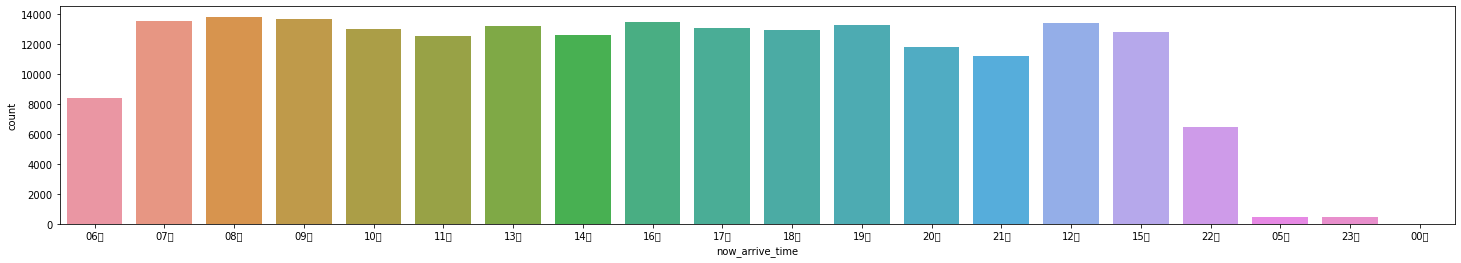

In [27]:
plt.figure(figsize=(25,4))
sns.countplot(data = train, x= "now_arrive_time")


/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_text(s, 0, flags=flags)


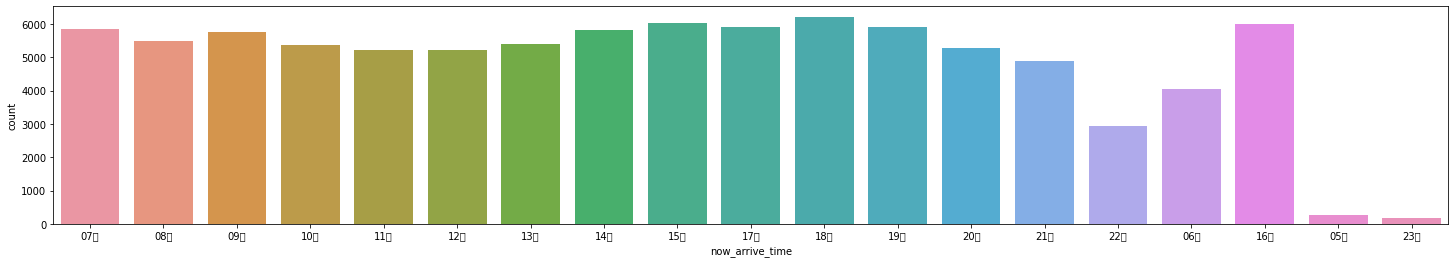

In [28]:
plt.figure(figsize=(25,4))
sns.countplot(data=test,x="now_arrive_time")

# 00시가 test data에서는 존재하지 않는다.


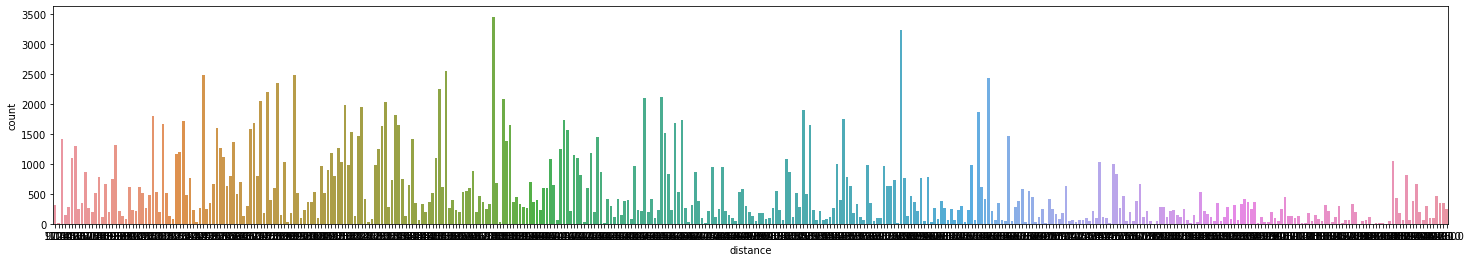

In [29]:
plt.figure(figsize=(25,4))
sns.countplot(data = train,x = "distance")


# 거리가 뚜렷한 경향이 보이지는 않지만 distance가 큰 정류장은 작아보인다.


In [30]:
train.next_station.value_counts()

은남동                3519
제주여자중고등학교(아라방면)    3207
아라주공아파트            3190
인다마을               3105
제원아파트              2553
                   ... 
서귀포동부도서관             12
하도리 개긋물              10
전경대 입구                7
제주버스터미널(가상정류소)        3
제주한라대학교               2
Name: next_station, Length: 351, dtype: int64

In [31]:
test.next_station.value_counts()

은남동                1550
아라주공아파트            1539
인다마을               1505
제주여자중고등학교(아라방면)    1292
제원아파트              1249
                   ... 
세화고등학교                6
서귀포동부도서관              4
하도리 개긋물               2
제주한라대학교               1
제주버스터미널(가상정류소)        1
Name: next_station, Length: 350, dtype: int64

next station은 test data에서 또 하나가 적다.
아마 전경대 입구가 아닐까......?

In [32]:
test[test['next_station']=='전경대 입구']

# 전경대 입구가 없다.

,id,date,route_id,vh_id,route_nm,now_latitude,now_longitude,now_station,now_arrive_time,distance,next_station,next_latitude,next_longitude


In [33]:
train.next_arrive_time.value_counts()

44      5704
42      5693
46      5624
40      5464
50      5342
        ... 
2046       1
1624       1
1016       1
1442       1
1392       1
Name: next_arrive_time, Length: 596, dtype: int64

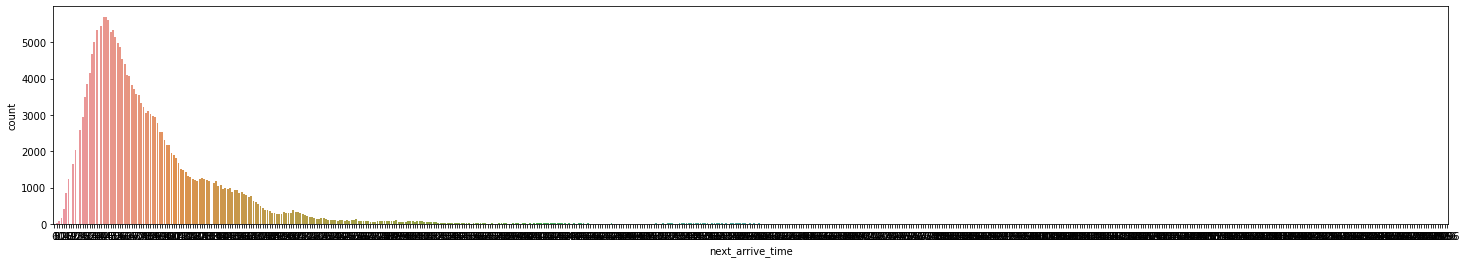

In [34]:
plt.figure(figsize=(25,4))
sns.countplot(data=train, x="next_arrive_time")

In [35]:
train = train.sort_values(by='next_arrive_time')

In [36]:
train['next_arrive_time'].describe()

count    210457.000000
mean         85.380824
std          85.051170
min           6.000000
25%          44.000000
50%          66.000000
75%         102.000000
max        2996.000000
Name: next_arrive_time, dtype: float64

이상치로 보이는 값들은 좀 없앨 필요가 있어 보인다.
이상치를 어떻게 판별할 수 있을까?

data cleansing & pre-processing

In [46]:
# now_arrive_time 에 문자를 빼서 바로 수치형으로 바꿔줘야 한다.
train.now_arrive_time

69268     21시
115127    12시
205488    14시
10128     19시
162746    09시
         ... 
2003      17시
150855    08시
110733    07시
34404     19시
35950     18시
Name: now_arrive_time, Length: 210457, dtype: object

In [50]:
train['now_arrive_time'] = train['now_arrive_time'].str.slice(stop=-1).astype('int')

In [51]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 210457 entries, 69268 to 35950
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                210457 non-null  int64  
 1   date              210457 non-null  object 
 2   route_id          210457 non-null  int64  
 3   vh_id             210457 non-null  int64  
 4   route_nm          210457 non-null  object 
 5   now_latitude      210457 non-null  float64
 6   now_longitude     210457 non-null  float64
 7   now_station       210457 non-null  object 
 8   now_arrive_time   210457 non-null  int64  
 9   distance          210457 non-null  float64
 10  next_station      210457 non-null  object 
 11  next_latitude     210457 non-null  float64
 12  next_longitude    210457 non-null  float64
 13  next_arrive_time  210457 non-null  int64  
dtypes: float64(5), int64(5), object(4)
memory usage: 24.1+ MB


In [52]:
test['now_arrive_time'] = test['now_arrive_time'].str.slice(stop=-1).astype('int')

In [53]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91774 entries, 0 to 91773
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               91774 non-null  int64  
 1   date             91774 non-null  object 
 2   route_id         91774 non-null  int64  
 3   vh_id            91774 non-null  int64  
 4   route_nm         91774 non-null  object 
 5   now_latitude     91774 non-null  float64
 6   now_longitude    91774 non-null  float64
 7   now_station      91774 non-null  object 
 8   now_arrive_time  91774 non-null  int64  
 9   distance         91774 non-null  float64
 10  next_station     91774 non-null  object 
 11  next_latitude    91774 non-null  float64
 12  next_longitude   91774 non-null  float64
dtypes: float64(5), int64(4), object(4)
memory usage: 9.1+ MB


Modeling

In [54]:
# features에 이것만 넣어서 해보자.

features = ['now_latitude','now_longitude','now_arrive_time','distance']
target = ['next_arrive_time']


In [55]:
X_train,X_test,y_train = train[features],test[features],train[target]


In [56]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression


In [61]:
# dictionary 만들어서 모델을 모아두기.
model_dict = {
    'linear':LinearRegression(),
    'rf' : RandomForestRegressor(random_state=0, n_jobs=-1),
    'lgbm':lgb.LGBMRegressor(random_state=0)
}

In [62]:
model_dict

{'linear': LinearRegression(),
 'rf': RandomForestRegressor(n_jobs=-1, random_state=0),
 'lgbm': LGBMRegressor(random_state=0)}

In [63]:
model_dict.keys()

dict_keys(['linear', 'rf', 'lgbm'])

In [64]:
model_dict['linear']

LinearRegression()

In [67]:
model_result = {}

for key in model_dict.keys():
  print('##### 훈련중 #####')
  model_dict[key].fit(X_train,y_train)
  print('##### 예측중 #####')
  model_result[key] = model_dict[key].predict(X_test)


##### 훈련중 #####
##### 예측중 #####
##### 훈련중 #####


<ipython-input-67-e2d3d306f931>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_dict[key].fit(X_train,y_train)


##### 예측중 #####
##### 훈련중 #####
##### 예측중 #####


In [68]:
lr_submit=submission.copy()
rf_submit=submission.copy()
lgbm_submit = submission.copy()

In [69]:
lr_submit['next_arrive_time']= model_result['linear']
rf_submit['next_arrive_time']= model_result['rf']
lgbm_submit['next_arrive_time']= model_result['lgbm']

In [70]:
lr_submit.to_csv('lr_submit.csv',index=False)
rf_submit.to_csv('rf_submit.csv',index=False)
lgbm_submit.to_csv('lgbm_submit.csv',index=False)